# ODE System Identification with Monotonic Splines

The proposed method aims at a substantial speedup in exploring the fitness of large systems of ODEs w.r.t. provided full or partial data of variables' trajectories. These ODE systems are often found in physical and biochemical simulations. It is not feasible to expect a perfect qualitative match of a real physical system to its model variables' traces. Therefore, by exploring the fitness we mean the study of a Pareto-frontier in a space of per-variable fitness. Thus, as we are still aiming to attain the best fitness possible, we admit that, in general, we'll need to explore a top-K best fits of parameters w.r.t. the "closeness" of trajectories to the real data. The exploring may show that some variables are generally harder to fit than the others, which could yield improvements in the ODE model under study.

Preliminarily, the proposed method shows a possibility of attaining a representative sample of the referred Pareto-frontier with orders of magnitude fewer iterations, compute and time, as compared to a conventional approach of incorporating the solving of the ODE system along the calls of a fitness criterion being optimize

We are aware of the prior art in the area of dynamical systems parameter estimation, including the implementation in GEKKO library. For various reasons we could not obrain reliable operation of these implementations in our practice and given the size and complexity of operated ODE systems. We plan to pay more attention to comparing the prior art to proposed methods.d.

_Copyright (c) 2024: Dan Skaov_



In [1]:
# [1]
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize, least_squares, Bounds
from scipy.integrate import solve_ivp
from typing import List
import random
import math
import pandas as pd
from numba import jit

C:\Users\x1\AppData\Local\Temp\ipykernel_31200\2792803851.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parameters and settings

In [2]:
## Selection of fitness function: 'rmse' or 'mape'
OBJECTIVE_FUNCTION_TYPE = 'rmse'

# Number of points in t-grid for PCHIP spline derivative estimation
NUM_DERIVATIVE_POINTS = 30

# Number of t-points for plotting ODE solutions
NUM_PLOTTING_POINTS = 15

# Noise level for data trajectory
NOISE_LEVEL = 0.05

# Number of random starting points for optimization
NUM_RANDOM_STARTS = 10

# Timeout for each optimization in seconds
TIMEOUT = 120.0

In [3]:
# [2]
# Parameters
true_params = [2.5, 100.0, 6.0, 16.0, 100.0, 1.28, 12.0, 1.8, 13.0, 4.0, 0.52, 0.1, 1.0, 4.0]
param_names = ['J0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k', 'K', 'q', 'K1', 'psi', 'N_', 'A']

# Initial conditions
true_initial_conditions = [0.40, 1.50, 0.14, 0.20, 0.20, 1.00, 0.07]
variable_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# Time points for simulation
t_start = 0.0
t_end = 1.0
t_points = np.linspace(t_start, t_end, NUM_PLOTTING_POINTS)

In [4]:
# [3]
# Define the ODE function in Python
@jit(nopython=True)
def yeast_ode(t, S, P):
    S1, S2, S3, S4, S5, S6, S7 = S
    J0, k1, k2, k3, k4, k5, k6, k, K, q, K1, psi, N_, A = P
    dS1 = J0 - k1*S1*S6/(1+(S6/K1)**4)
    dS2 = 2*k1*S1*S6/(1+(S6/K1)**4) - k2*S2*(N_-S5) - k6*S2*S5
    dS3 = k2*S2*(N_-S5) - k3*S3*(A-S6)
    dS4 = k3*S3*(A-S6) - k4*S4*S5 - K*(S4-S7)
    dS5 = k2*S2*(N_-S5) - k4*S4*S5 - k6*S2*S5
    dS6 = -2*k1*S1*S6/(1+(S6/K1)**4) + 2*k3*S3*(A-S6) - k5*S6
    dS7 = psi*K*(S4-S7) - k*S7
    return [dS1, dS2, dS3, dS4, dS5, dS6, dS7]

In [5]:
# [4]
# Solve the ODE problem to get the 'true' trajectory
def yeast_ode_wrapper(t, S):
    return yeast_ode(t, S, true_params)

sol = solve_ivp(yeast_ode_wrapper, [t_start, t_end], true_initial_conditions, t_eval=t_points, method='RK45')
true_solution = sol.y.T  # Shape: (len(t_points), num_variables)

In [6]:
# [5]
# Generate 'data' trajectory
data_solution = true_solution.copy()

# Flip the first and third variables upside down
# data_solution[:, 0] = np.max(data_solution[:, 0]) - data_solution[:, 0] + np.min(data_solution[:, 0])
# data_solution[:, 2] = np.max(data_solution[:, 2]) - data_solution[:, 2] + np.min(data_solution[:, 2])

# Add small noise to other variables (excluding first and third)
for i in range(data_solution.shape[1]):
    if i not in [0, 2]:
        noise = NOISE_LEVEL * np.random.randn(len(t_points)) * np.abs(data_solution[:, i])
        data_solution[:, i] += noise

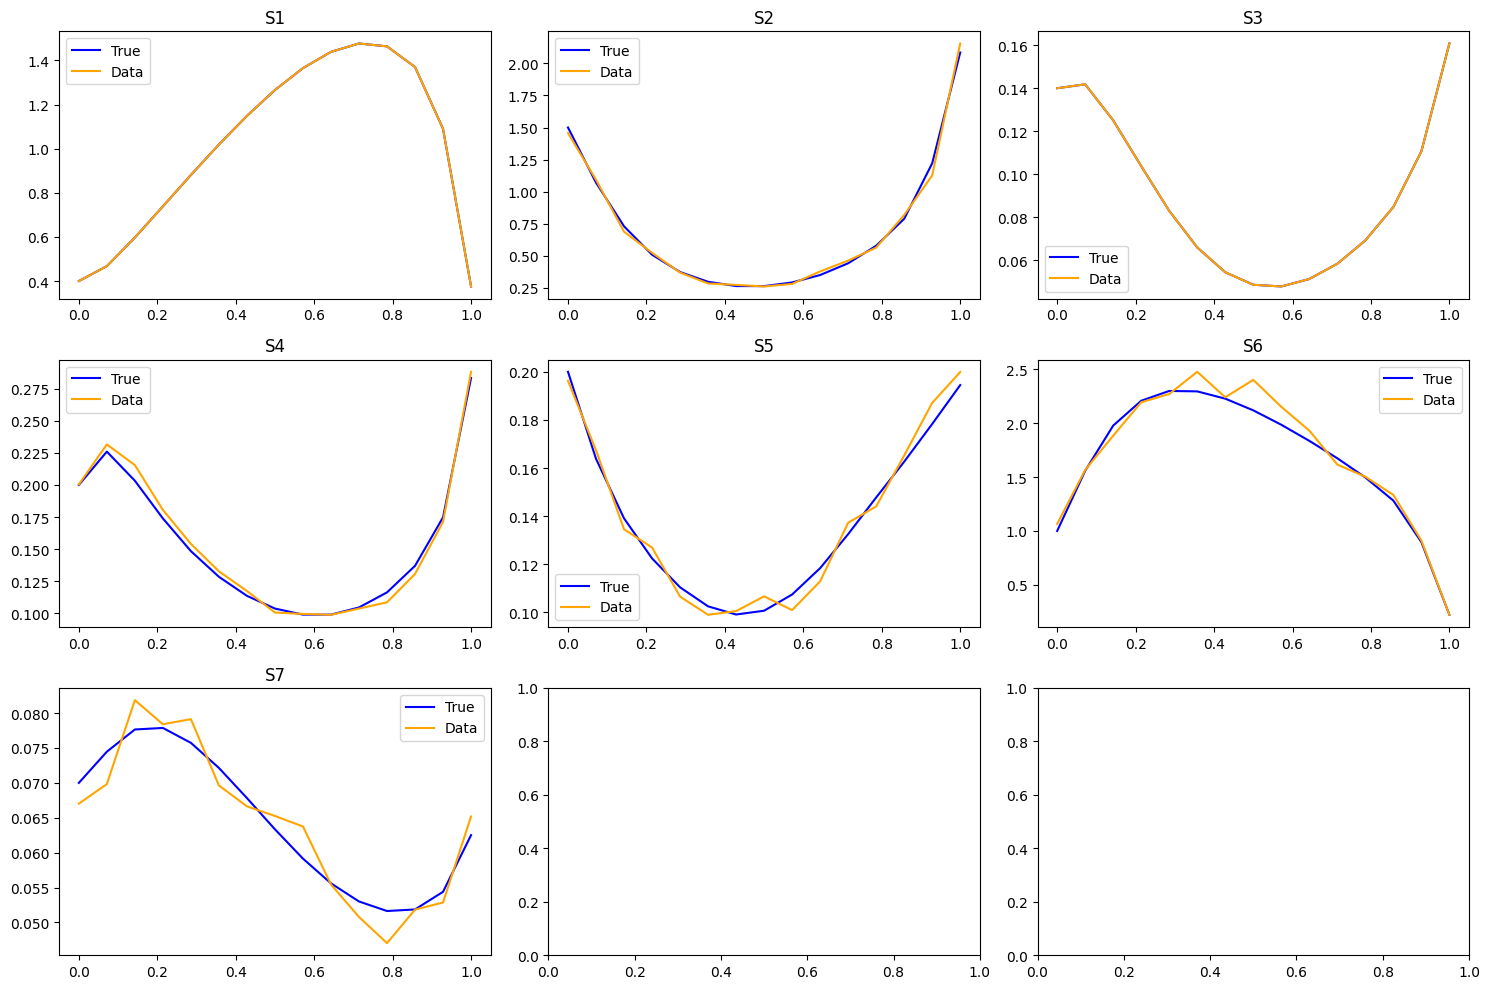

In [7]:
# [6]
# Plot the 'true' and 'data' trajectories
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes[:7]):
    ax.plot(t_points, true_solution[:, i], label='True', color='blue')
    ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
    ax.set_title(variable_names[i])
    ax.legend()

fig.tight_layout()
plt.show()

In [8]:
# [7]
# Define the ObjectiveFunction class
class ObjectiveFunction:
    def __init__(self, ode_system, data_solution, t_points, num_variables, objective_function_type=OBJECTIVE_FUNCTION_TYPE, timeout=TIMEOUT, lower_bounds=None, upper_bounds=None):
        self.ode_system = ode_system
        self.data_solution = data_solution
        self.t_points = t_points
        self.num_variables = num_variables
        self.objective_function_type = objective_function_type
        self.func_values = []
        self.per_variable_distances = []
        self.iterations = 0
        self.start_time = time.time()
        self.timeout = timeout
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds

    def __call__(self, params):
        if time.time() - self.start_time > self.timeout:
            raise TimeoutError("Objective function evaluation timed out.")

        # Check if params are within bounds
        if self.lower_bounds is not None and np.any(params < self.lower_bounds):
            return np.inf
        if self.upper_bounds is not None and np.any(params > self.upper_bounds):
            return np.inf

        self.iterations += 1
        num_initial_conditions = self.num_variables
        initial_conditions = params[:num_initial_conditions]
        ode_params = params[num_initial_conditions:]

        # Solve the ODE system
        try:
            def ode_system(t, S):
                return self.ode_system(t, S, ode_params)

            sol = solve_ivp(ode_system, [self.t_points[0], self.t_points[-1]], initial_conditions, t_eval=self.t_points, method='RK45')
            if not sol.success:
                return np.inf
            model_solution = sol.y.T  # Shape: (len(t_points), num_variables)
        except Exception as e:
            # If the ODE solver fails, return a high objective value
            return np.inf

        # Compute per-variable distances
        per_variable_distance = []
        for i in range(self.num_variables):
            data_seq = self.data_solution[:, i]
            model_seq = model_solution[:, i]

            # Scale data_seq to [0,1], per variable
            data_min = data_seq.min()
            data_max = data_seq.max()
            if data_max - data_min == 0:
                data_scaled = np.zeros_like(data_seq)
                model_scaled = np.zeros_like(model_seq)
            else:
                data_scaled = (data_seq - data_min) / (data_max - data_min)
                model_scaled = (model_seq - data_min) / (data_max - data_min)

            if self.objective_function_type == 'rmse':
                distance = np.sqrt(np.mean((data_scaled - model_scaled) ** 2))
            elif self.objective_function_type == 'mape':
                distance = np.mean(np.abs((data_scaled - model_scaled) / (data_scaled + 1e-8)))
            else:
                raise ValueError("Invalid objective_function_type. Choose 'rmse' or 'mape'.")

            per_variable_distance.append(distance)

        objective_value = np.sum(per_variable_distance)
        self.func_values.append(objective_value)
        self.per_variable_distances.append(per_variable_distance)
        return objective_value

In [9]:
# [8]
# Function to plot trajectories
def plot_fit(result, method_name, fit_idx):
    x = result['x']
    initial_conditions = x[:len(true_initial_conditions)]
    ode_params = x[len(true_initial_conditions):]

    # Solve the ODE system
    def ode_system(t, S):
        return yeast_ode(t, S, ode_params)

    sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='RK45')
    model_solution = sol.y.T  # Shape: (len(t_points), num_variables)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:7]):
        ax.plot(t_points, model_solution[:, i], label='Fitted', color='red')
        ax.plot(t_points, true_solution[:, i], label='True', color='blue')
        ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
        ax.set_title(variable_names[i])
        ax.legend()

    fig.suptitle(f'{method_name} - Fit {fit_idx+1}', fontsize=16)
    plt.tight_layout()
    plt.show()


## Classical method: Parameter estimation using Nelder-Mead optimization starting from random points

In [10]:
# [9]
# Classical method
num_params = len(true_initial_conditions) + len(true_params)
param_bounds = []
for i in range(num_params):
    if i < len(true_initial_conditions):
        # For initial conditions
        val = true_initial_conditions[i]
    else:
        # For parameters
        val = true_params[i - len(true_initial_conditions)]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

# No bounds for Nelder-Mead, but we can check bounds in the ObjectiveFunction
lower_bounds = np.array([b[0] for b in param_bounds])
upper_bounds = np.array([b[1] for b in param_bounds])

results = []

print("Starting Classical Method Optimization...")
for idx in range(NUM_RANDOM_STARTS):
    # Generate random starting point in the hypercube
    x0 = [random.uniform(b[0], b[1]) for b in param_bounds]

    # Create an instance of the ObjectiveFunction
    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

    try:
        res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 1000})
        results.append({
            'x': res.x,
            'fun': res.fun,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Objective Value = {res.fun}")
    except TimeoutError:
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Timeout")
        continue

print("Classical Method Optimization Completed.")


Starting Classical Method Optimization...
Iteration 1/10: Objective Value = 4.432857801862921
Iteration 2/10: Objective Value = 6.718286901097209
Iteration 3/10: Objective Value = 3.5341839260442995
Iteration 4/10: Objective Value = 21.09739655197999
Iteration 5/10: Objective Value = 5.897817766361262
Iteration 6/10: Objective Value = 11.771189392202741
Iteration 7/10: Objective Value = 6.158294314664552
Iteration 8/10: Objective Value = 4.271479434149645
Iteration 9/10: Objective Value = 11.287583782557899
Iteration 10/10: Objective Value = 12.144019926949817
Classical Method Optimization Completed.


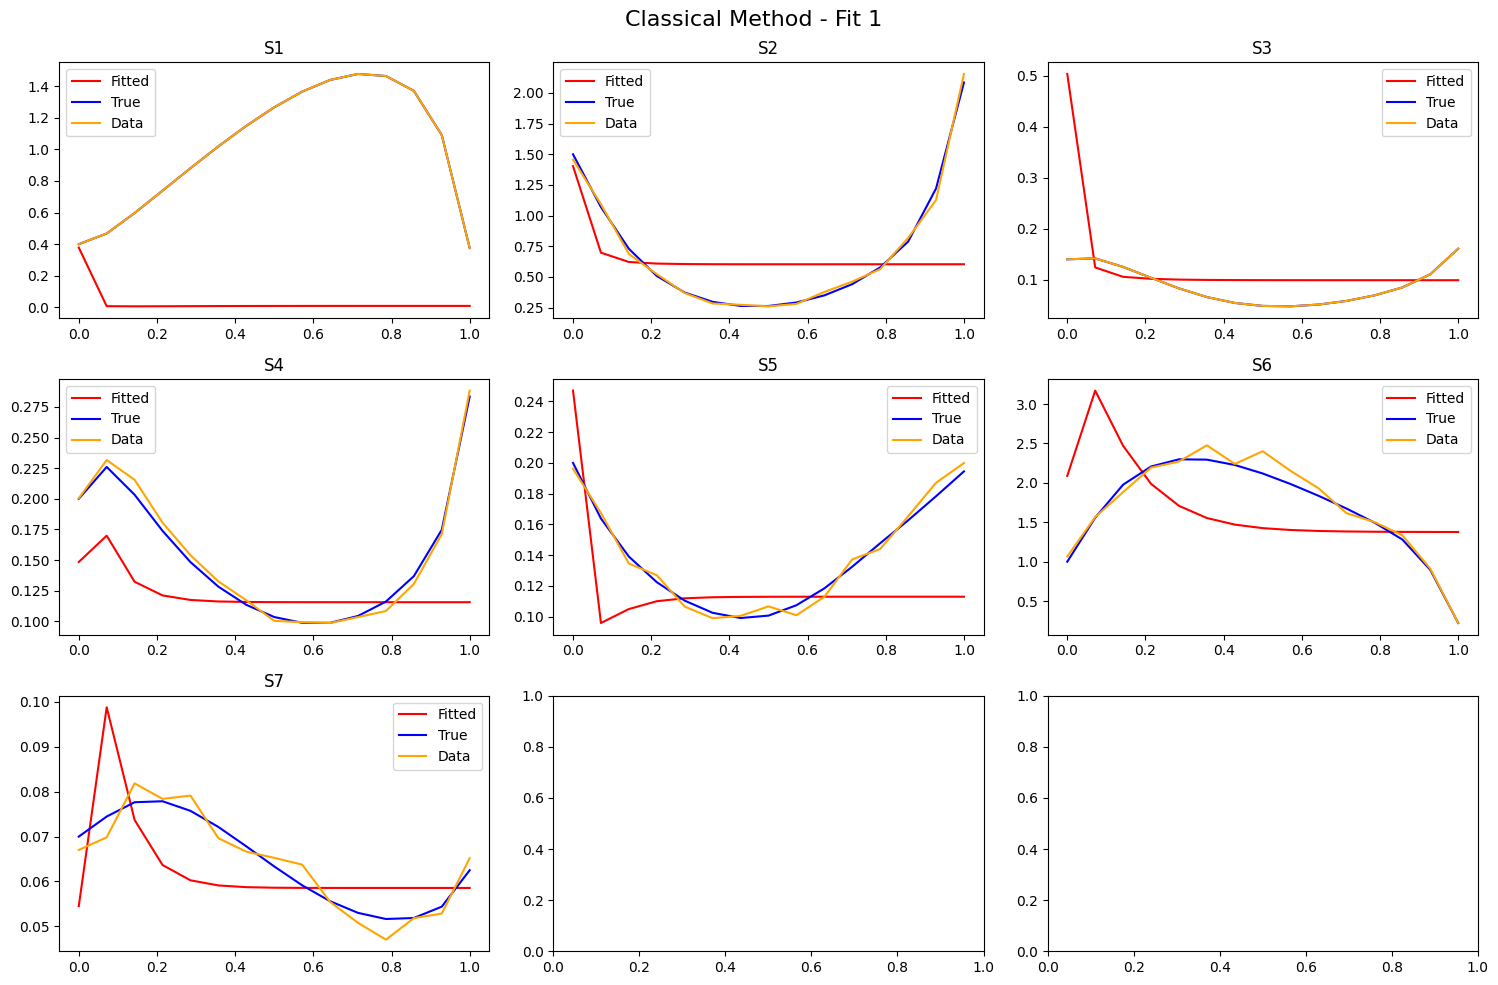

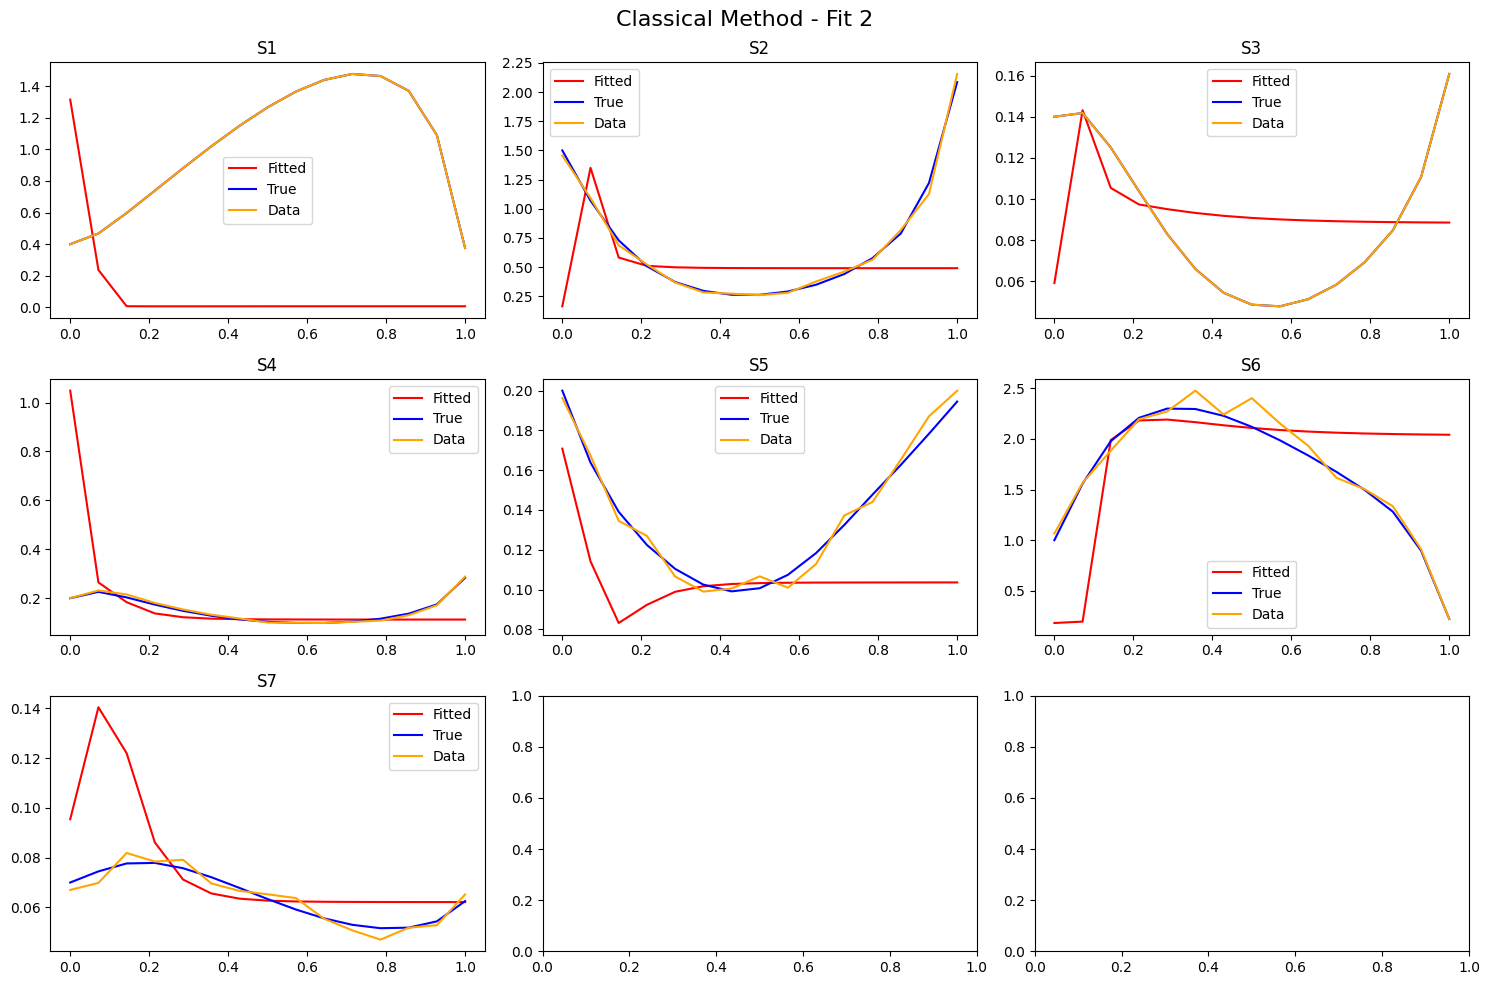

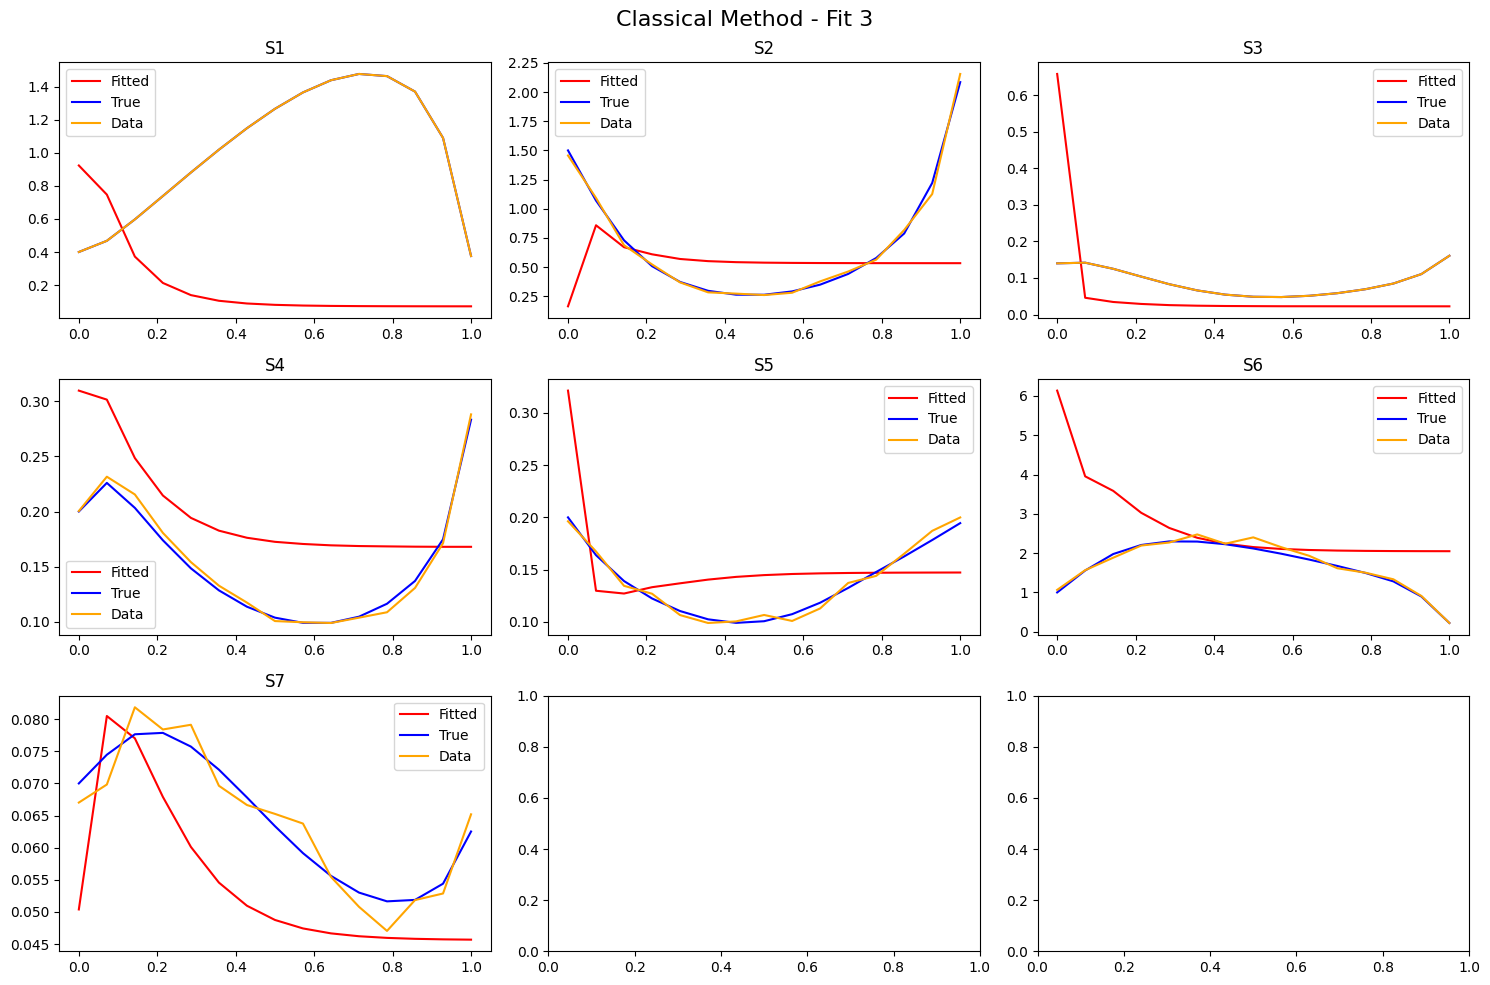

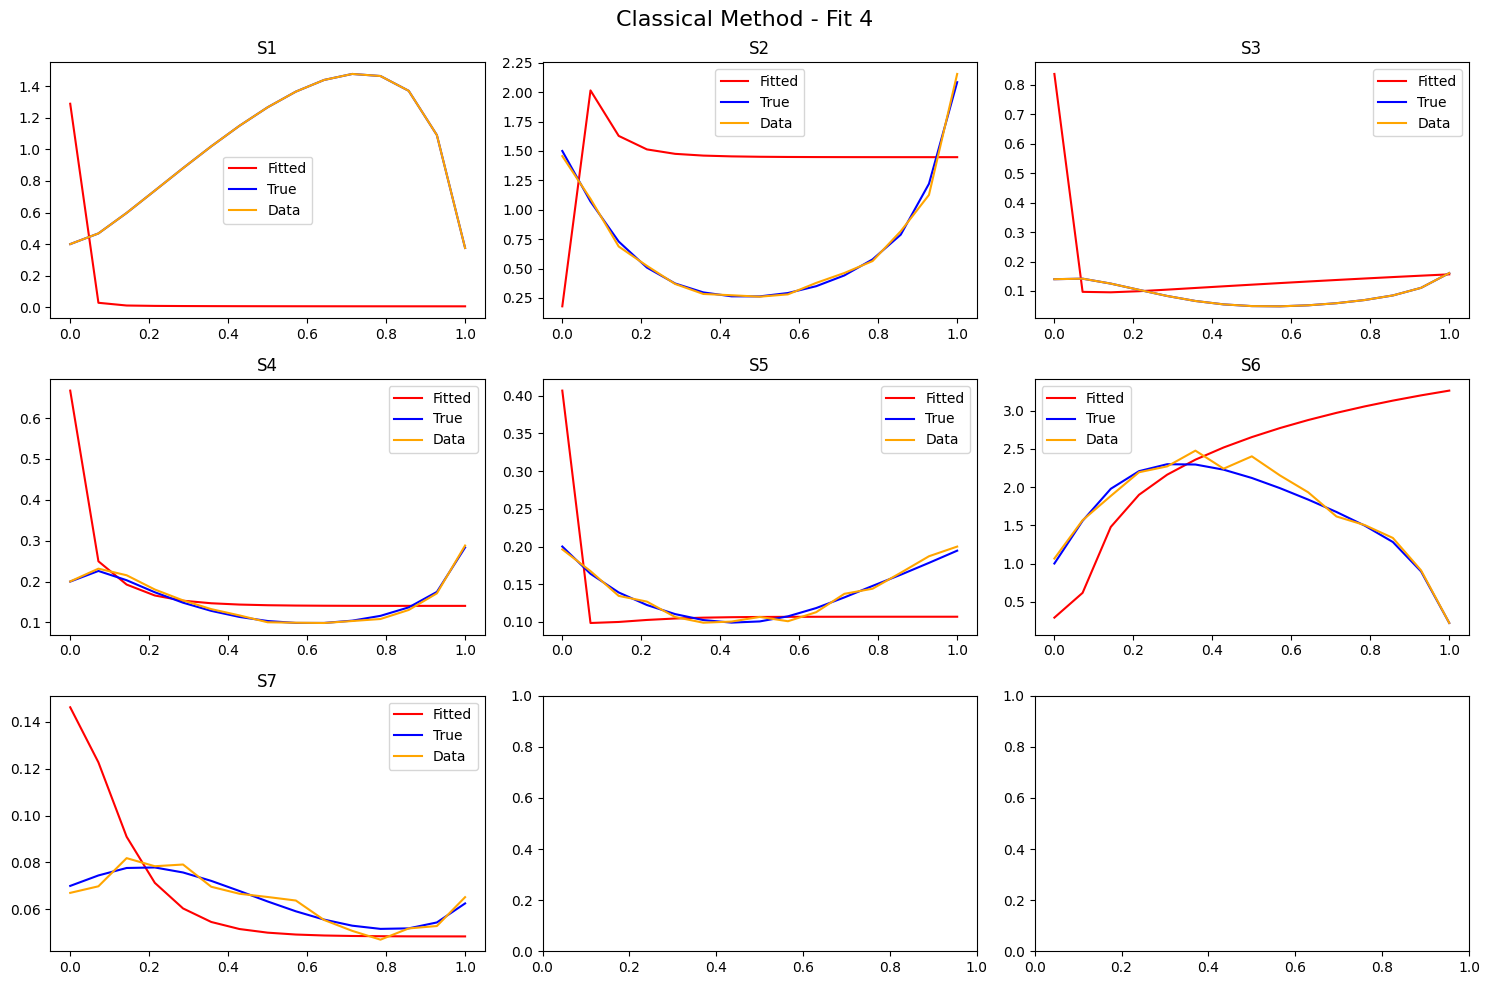

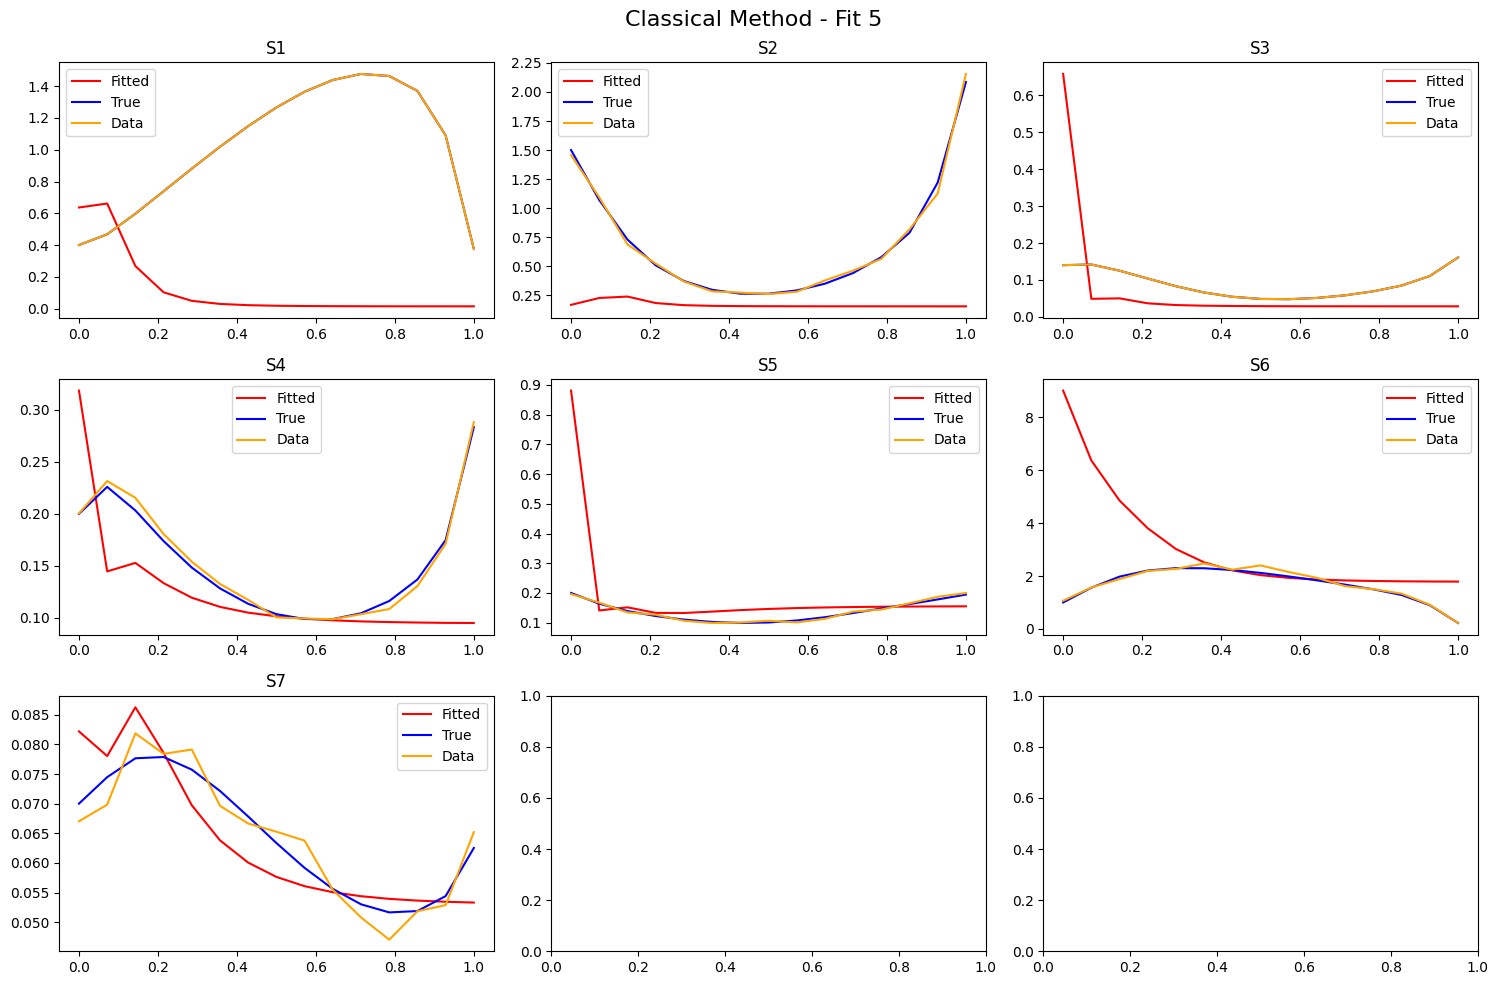

In [11]:
# [10]
# Sort the results by objective function value
sorted_results = sorted(results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_results[:5]):
    plot_fit(result, 'Classical Method', idx)

## Innovative method: Using PCHIP splines and derivative estimation to set up nonlinear equations

In [12]:
# [11]
# Innovative method
# Create PCHIP interpolators for each variable
pchip_splines = []
for i in range(data_solution.shape[1]):
    spline = PchipInterpolator(t_points, data_solution[:, i])
    pchip_splines.append(spline)

# Number of points for derivative estimation
t_grid = np.linspace(t_start, t_end, NUM_DERIVATIVE_POINTS)

# Prepare the data for the nonlinear system
derivatives = []
variable_values = []

for t in t_grid:
    vars_at_t = []
    derivs_at_t = []
    for spline in pchip_splines:
        vars_at_t.append(spline(t))
        derivs_at_t.append(spline.derivative()(t))
    variable_values.append(vars_at_t)
    derivatives.append(derivs_at_t)

variable_values = np.array(variable_values)  # Shape: (num_t_points, num_variables)
derivatives = np.array(derivatives)  # Shape: (num_t_points, num_variables)


In [13]:
# [13]
def residuals_function(P):
    residuals = []
    for i in range(len(t_grid)):
        S = variable_values[i]
        dS_dt = derivatives[i]
        f_S_P = yeast_ode(0, S, P)
        residual = dS_dt - f_S_P
        residuals.extend(residual)
    residuals = np.array(residuals)
    return residuals

# Bounds for parameters
param_bounds = []
for i in range(len(true_params)):
    val = true_params[i]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

param_bounds = ([b[0] for b in param_bounds], [b[1] for b in param_bounds])

# Get initial conditions from PCHIP spline at t=0
initial_conditions_innovative = []
for spline in pchip_splines:
    initial_conditions_innovative.append(spline(t_start))

In [14]:
# [14]
# Evaluate fitness for the innovative method
innovative_results = []

print("Starting Innovative Method Optimization...")
for idx in range(NUM_RANDOM_STARTS):
    # Random initial guess for parameters
    P0 = [random.uniform(0.1 * val, 10 * val) for val in true_params]

    try:
        res = least_squares(residuals_function, P0, bounds=param_bounds)
        # Solve the ODE with estimated parameters and initial conditions
        ode_params = res.x
        initial_conditions = initial_conditions_innovative

        def ode_system(t, S):
            return yeast_ode(t, S, ode_params)

        sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='RK45')
        if not sol.success:
            continue
        model_solution = sol.y.T  # Shape: (len(t_points), num_variables)

        # Compute objective function value
        obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names))
        fun_value = obj_func(np.concatenate([initial_conditions, ode_params]))

        innovative_results.append({
            'x': np.concatenate([initial_conditions, ode_params]),
            'fun': fun_value,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Objective Value = {fun_value}")
    except Exception as e:
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Exception occurred - {str(e)}")
        continue

print("Innovative Method Optimization Completed.")

Starting Innovative Method Optimization...
Iteration 1/10: Objective Value = 2.072799828519917
Iteration 2/10: Objective Value = 2.0728012701074667
Iteration 3/10: Objective Value = 2.0729300880412955
Iteration 4/10: Objective Value = 2.0727982836668057
Iteration 5/10: Objective Value = 2.0728002613972603
Iteration 6/10: Objective Value = 2.07280040499062
Iteration 7/10: Objective Value = 2.0728001797052116
Iteration 8/10: Objective Value = 2.0728030648693188
Iteration 9/10: Objective Value = 2.0728008181102027
Iteration 10/10: Objective Value = 2.072800260806088
Innovative Method Optimization Completed.


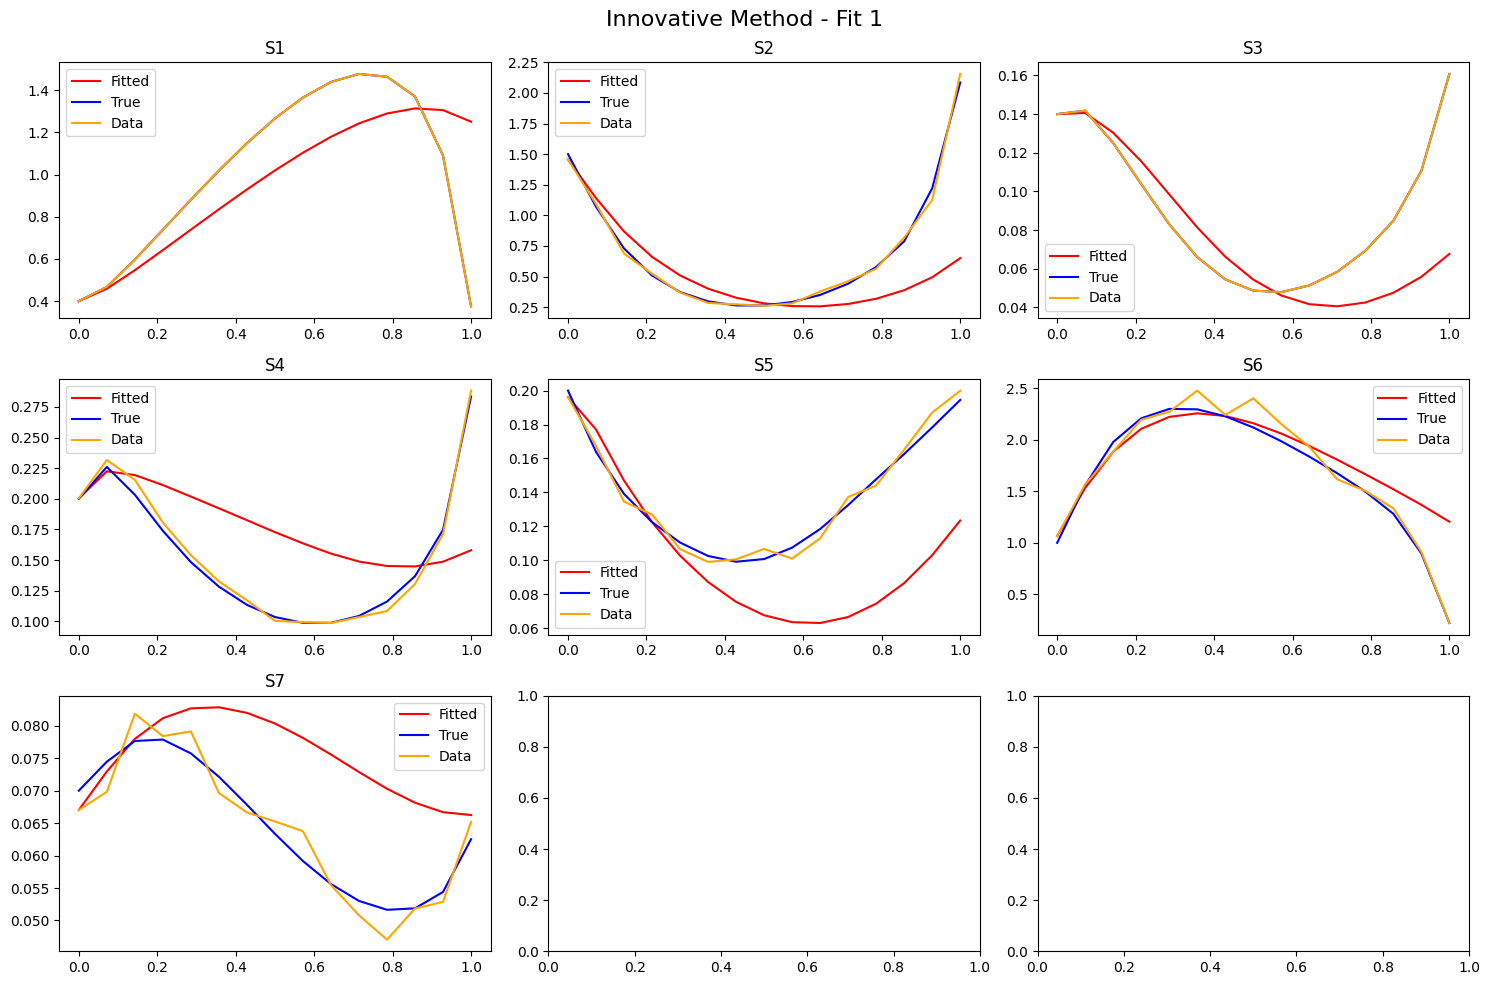

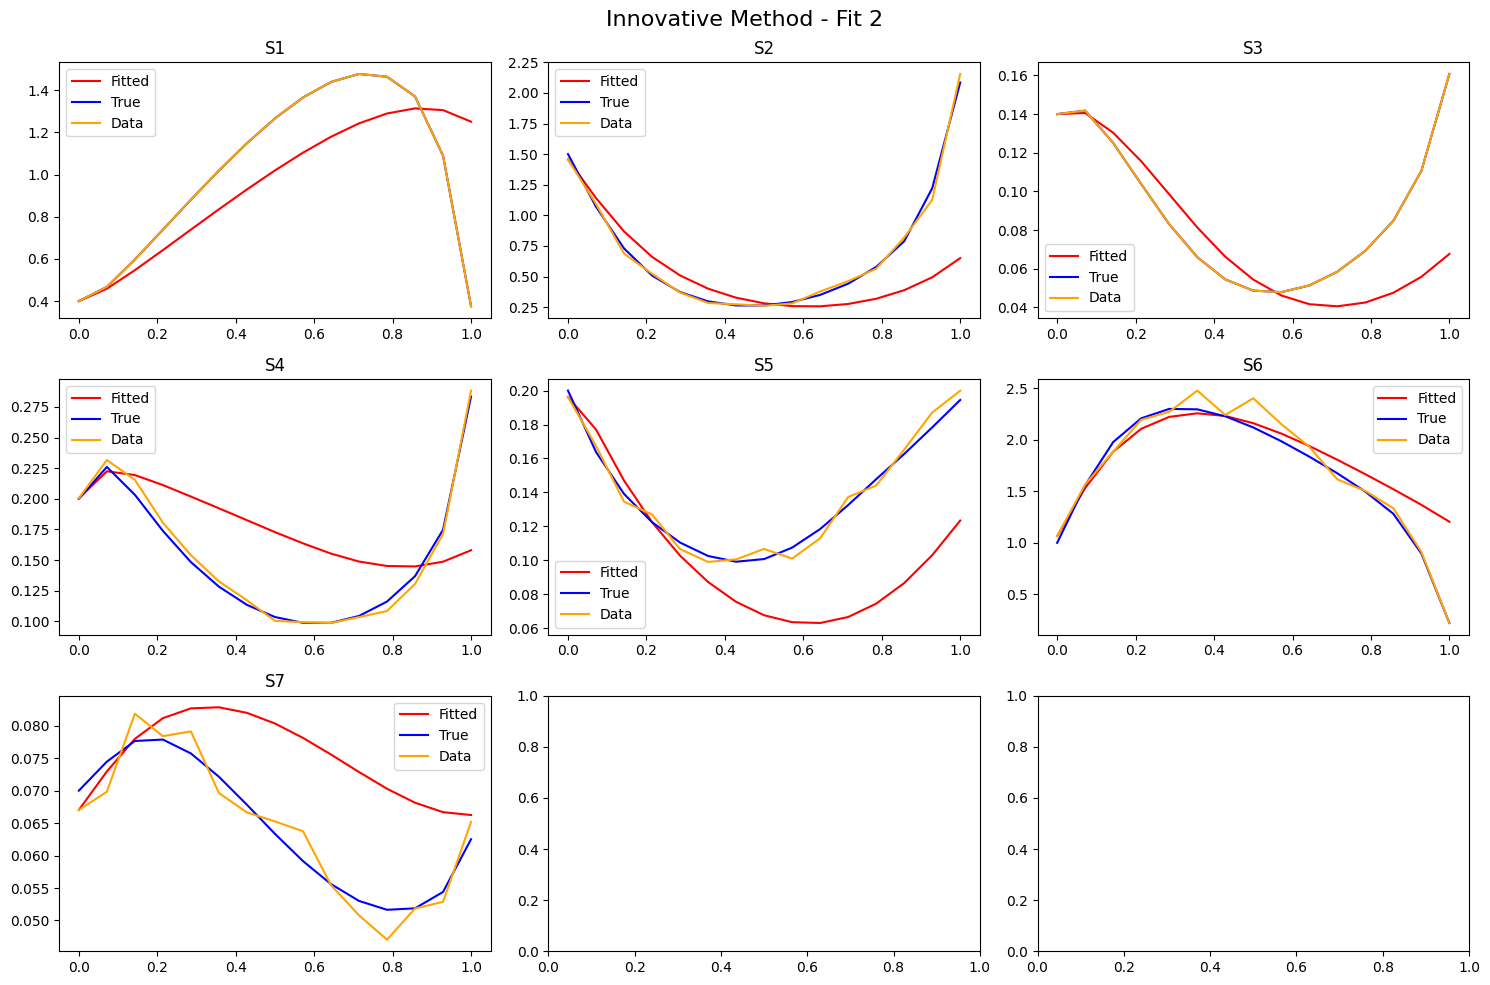

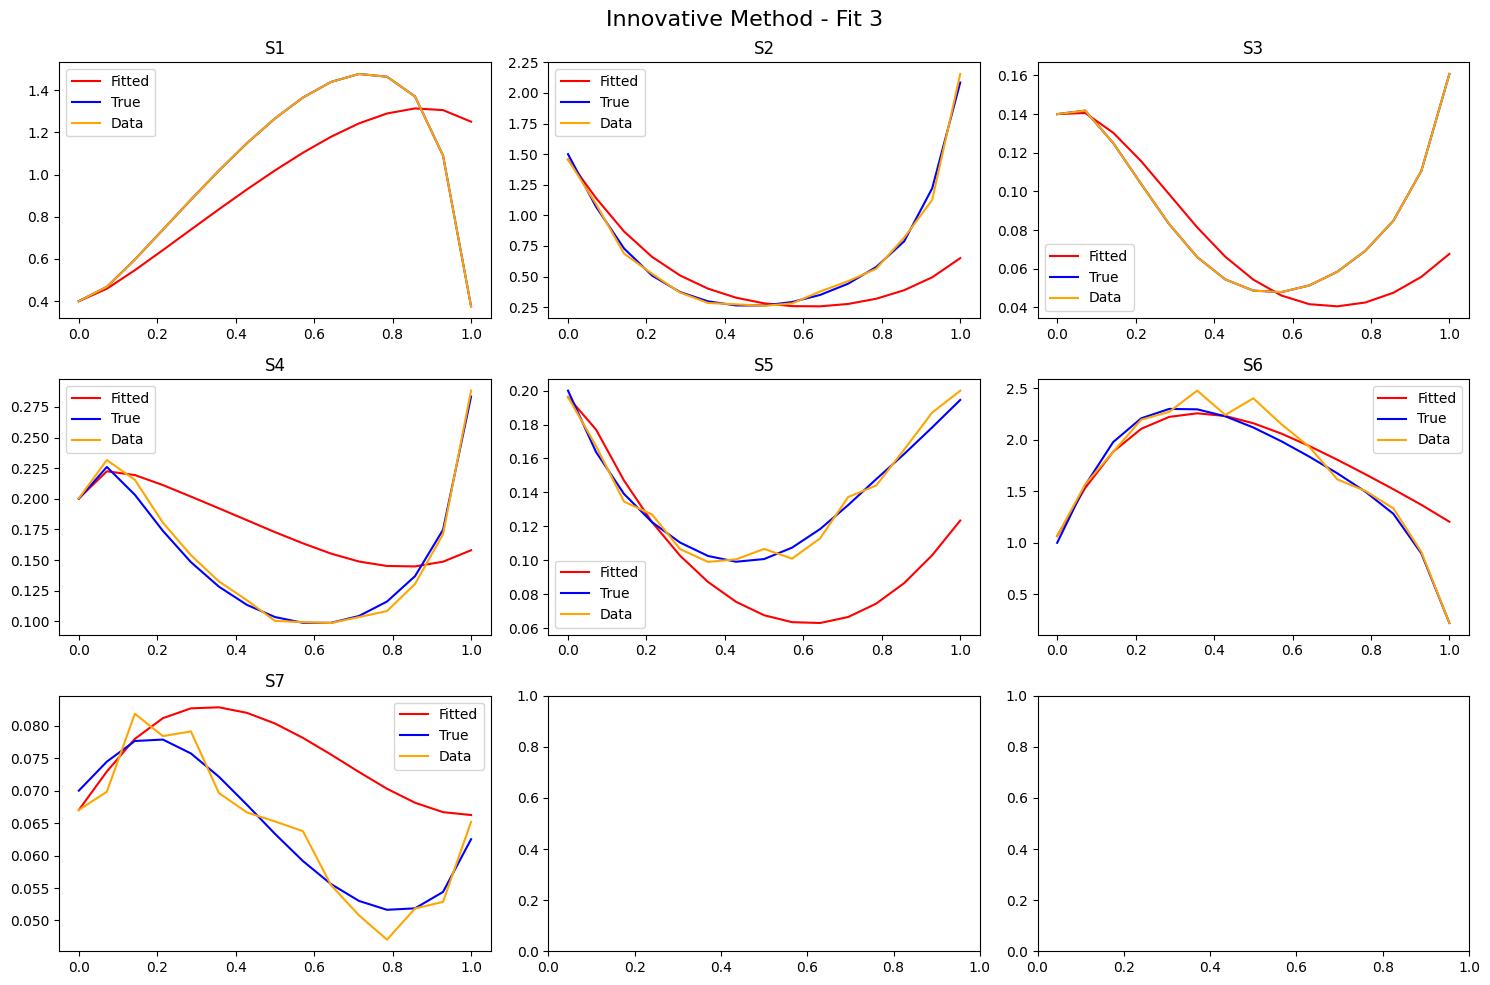

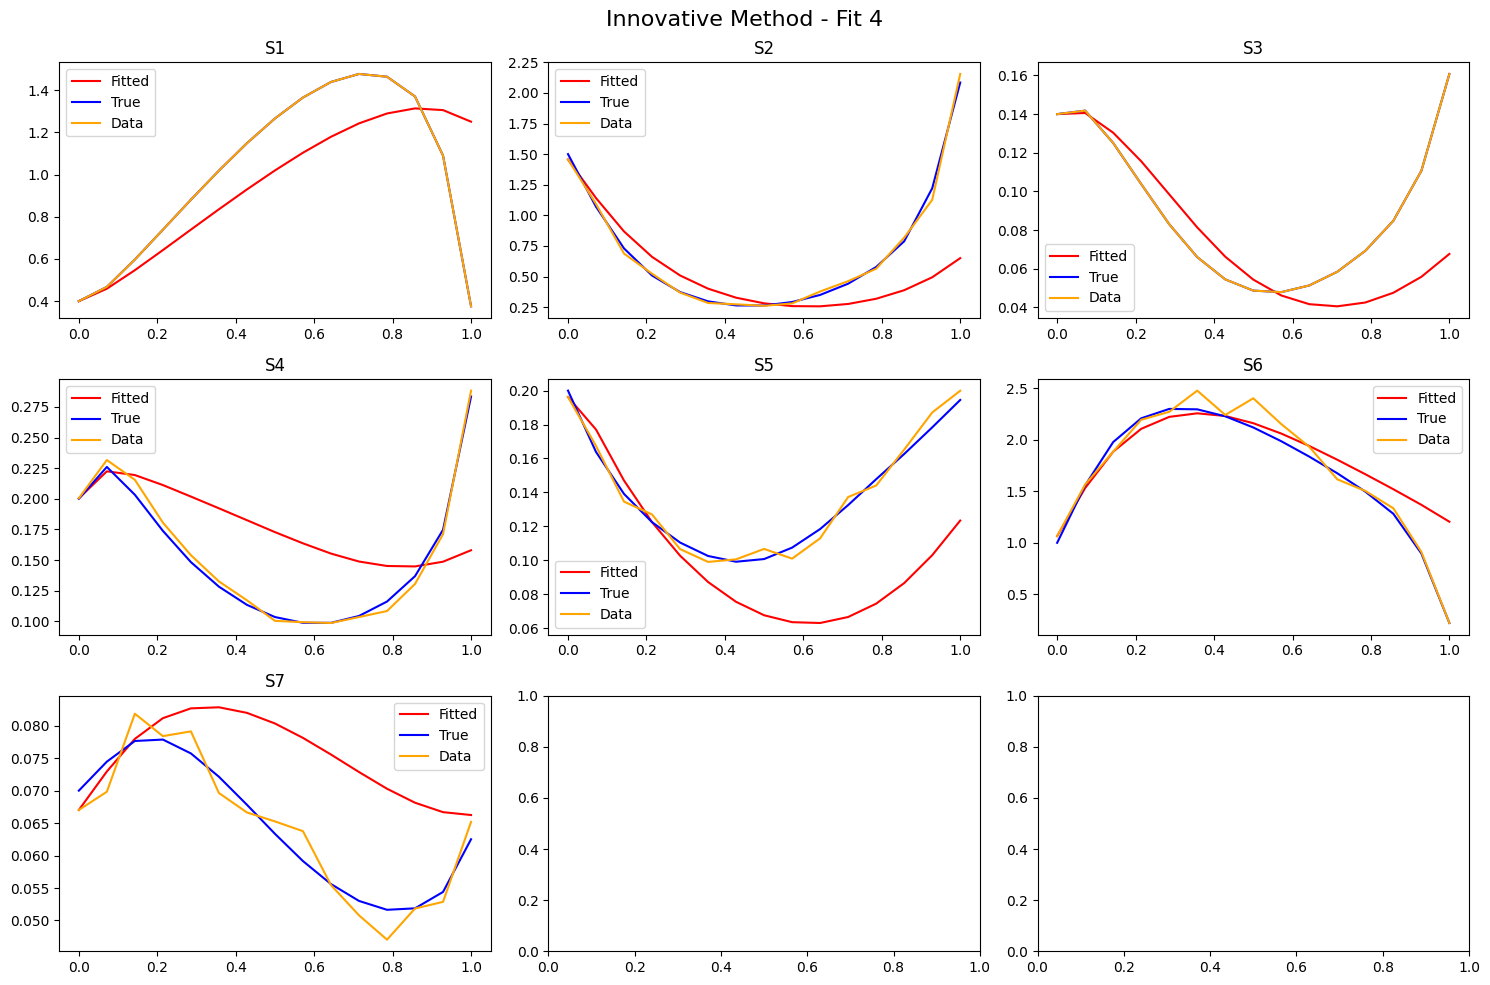

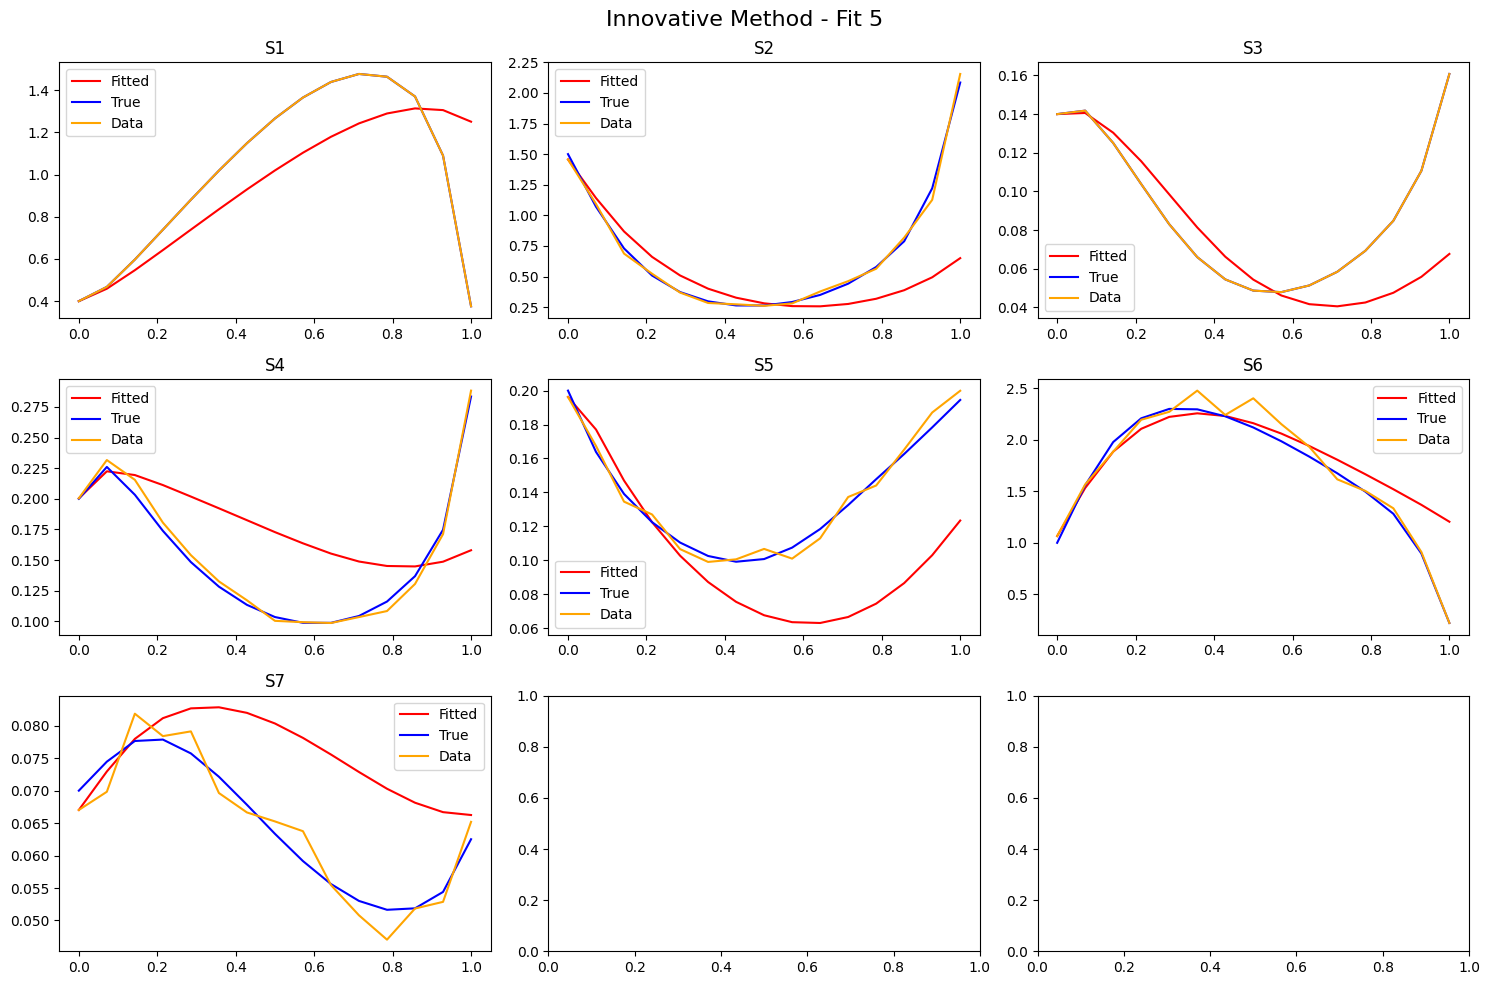

In [15]:
# [15]
# Sort the results by objective function value
sorted_innovative_results = sorted(innovative_results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_innovative_results[:5]):
    plot_fit(result, 'Innovative Method', idx)


## Hybrid method: Using solutions from the innovative method as starting points for the classical method

In [16]:
# [16]
# Hybrid method
hybrid_results = []

print("Starting Hybrid Method Optimization...")
for idx, result in enumerate(innovative_results):
    x0 = result['x']

    # Create an instance of the ObjectiveFunction
    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

    try:
        res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 1000})
        hybrid_results.append({
            'x': res.x,
            'fun': res.fun,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{len(innovative_results)}: Objective Value = {res.fun}")
    except TimeoutError:
        print(f"Iteration {idx+1}/{len(innovative_results)}: Timeout")
        continue

print("Hybrid Method Optimization Completed.")

Starting Hybrid Method Optimization...
Iteration 1/10: Objective Value = 0.7208793485666185
Iteration 2/10: Objective Value = 0.709446892626995
Iteration 3/10: Objective Value = 0.7147513217870541
Iteration 4/10: Objective Value = 0.6967617100998734
Iteration 5/10: Objective Value = 0.711838083855006
Iteration 6/10: Objective Value = 0.7094468300998026
Iteration 7/10: Objective Value = 0.7118380498904414
Iteration 8/10: Objective Value = 0.6277334284587561
Iteration 9/10: Objective Value = 0.6224233323978631
Iteration 10/10: Objective Value = 0.7118380916455382
Hybrid Method Optimization Completed.


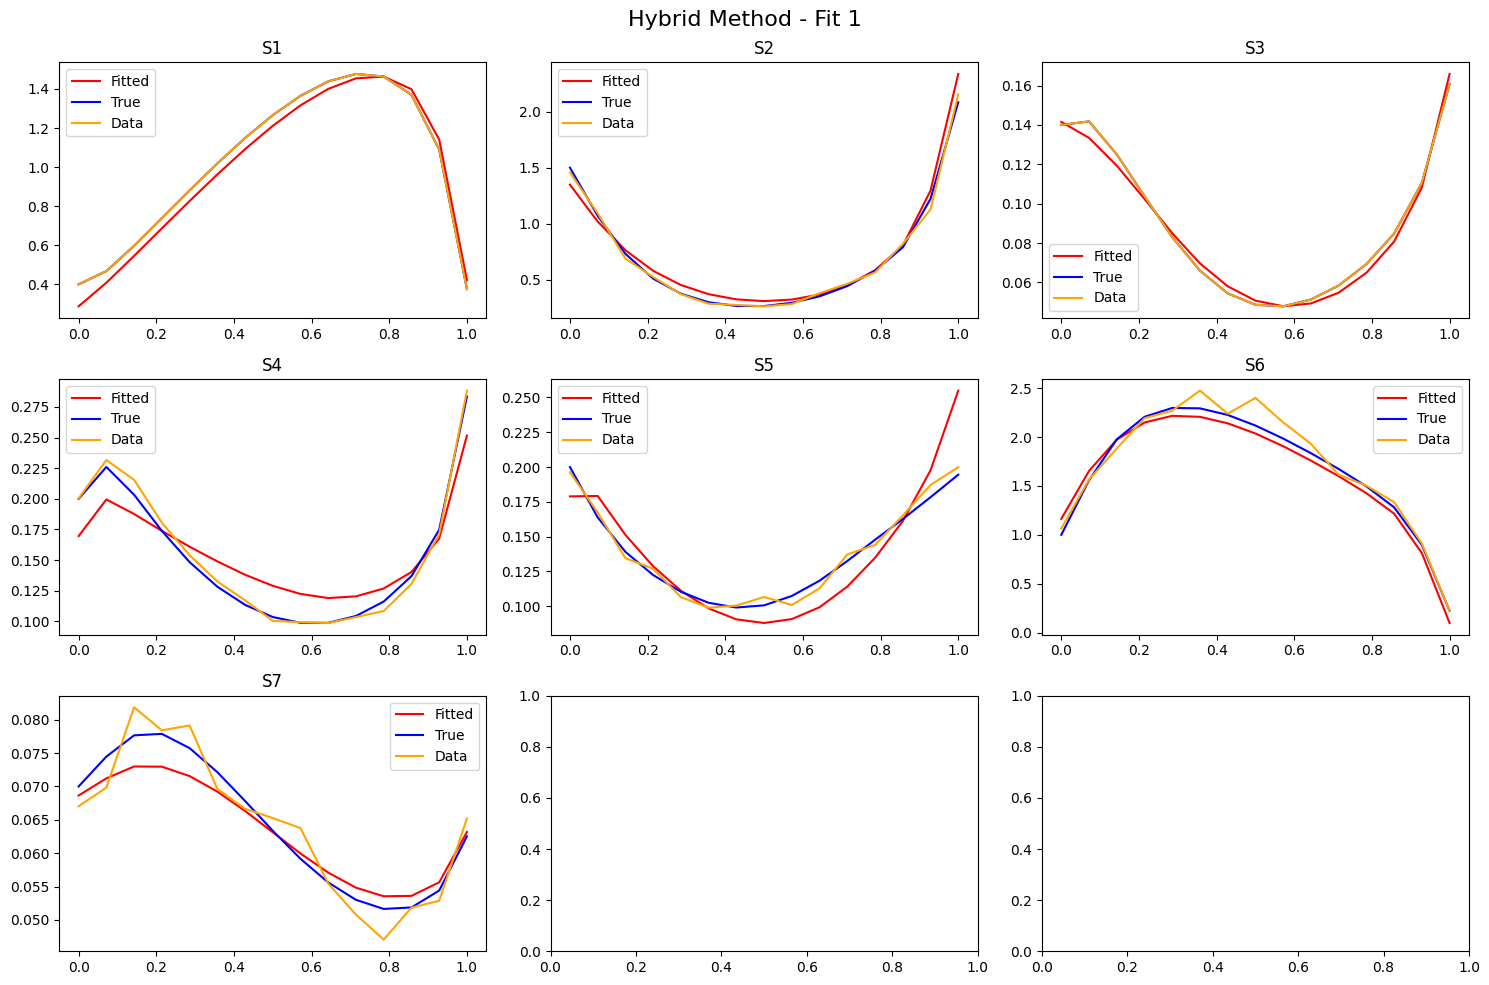

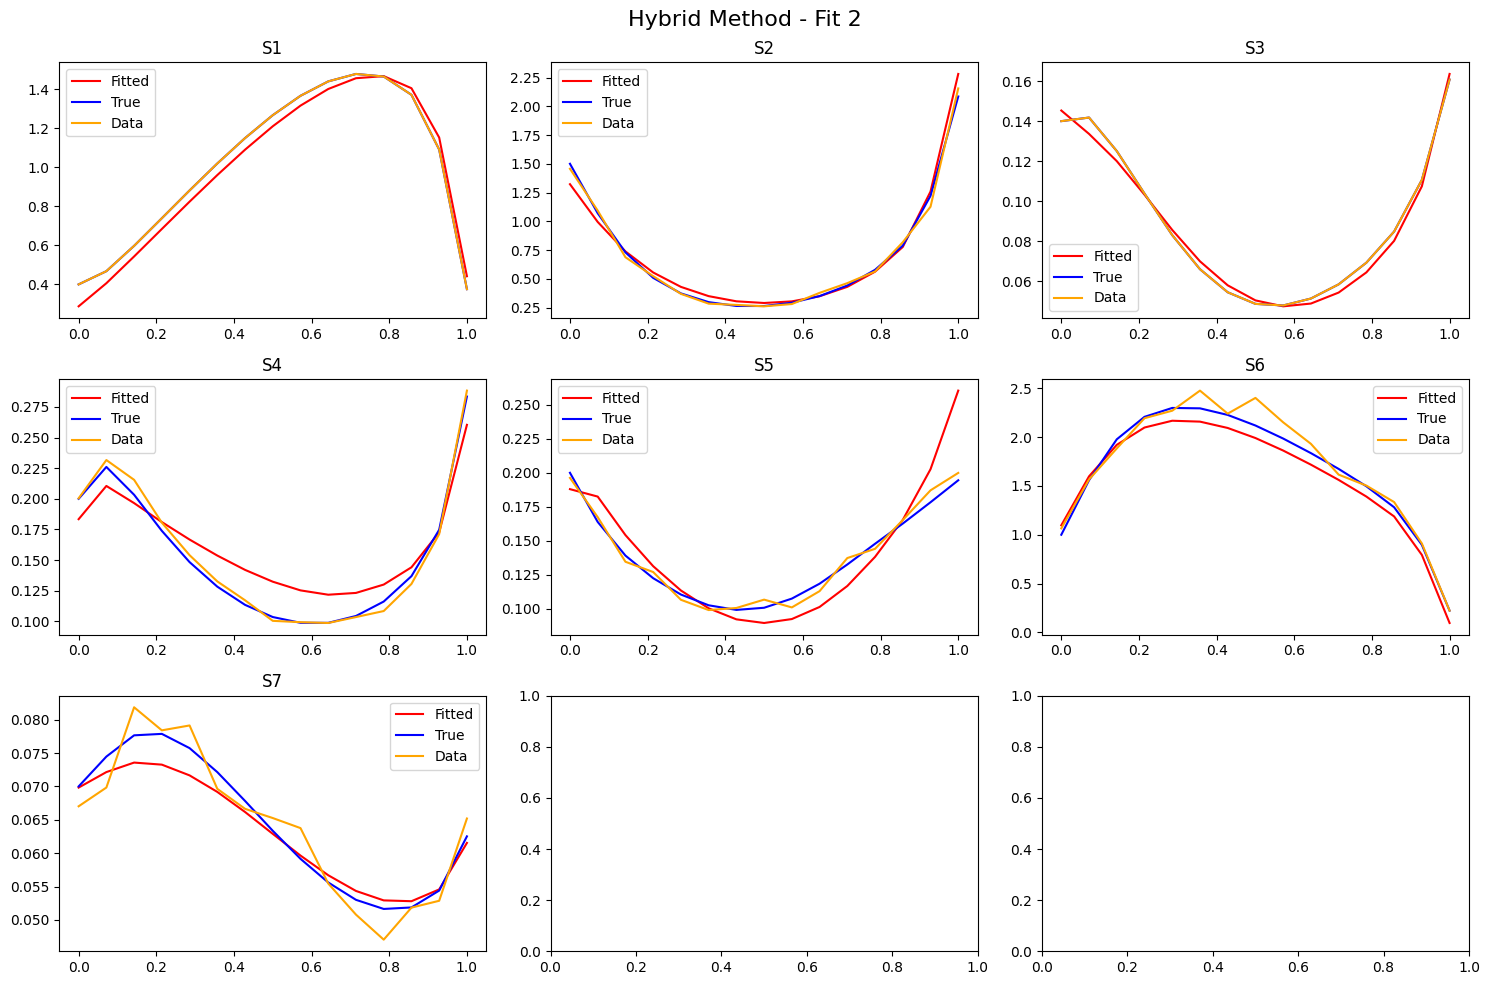

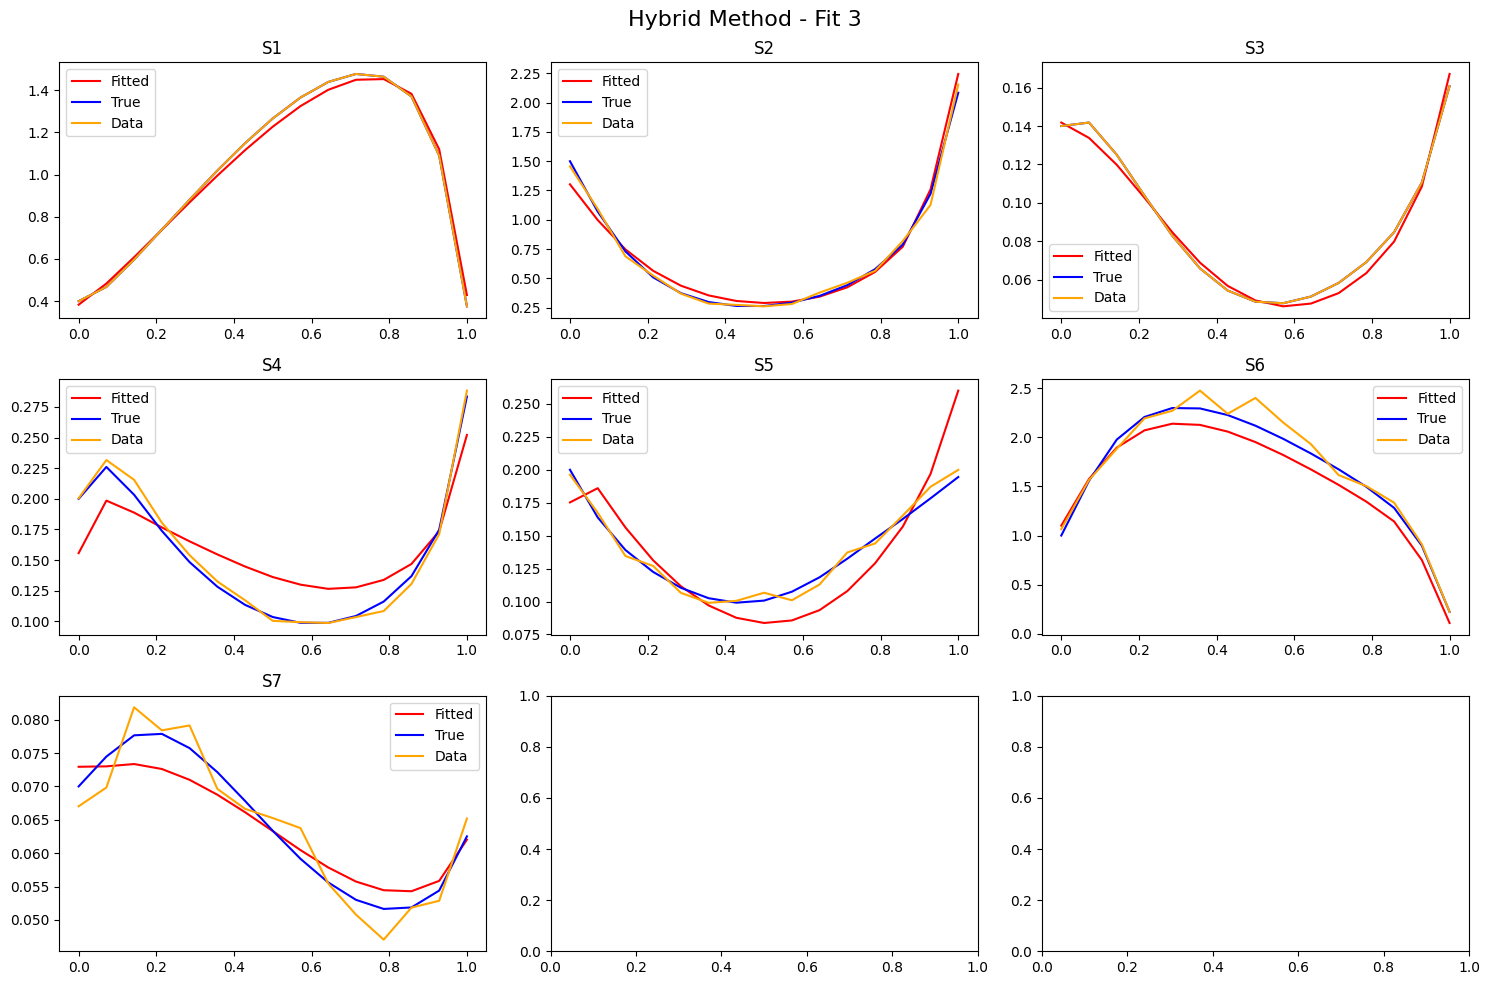

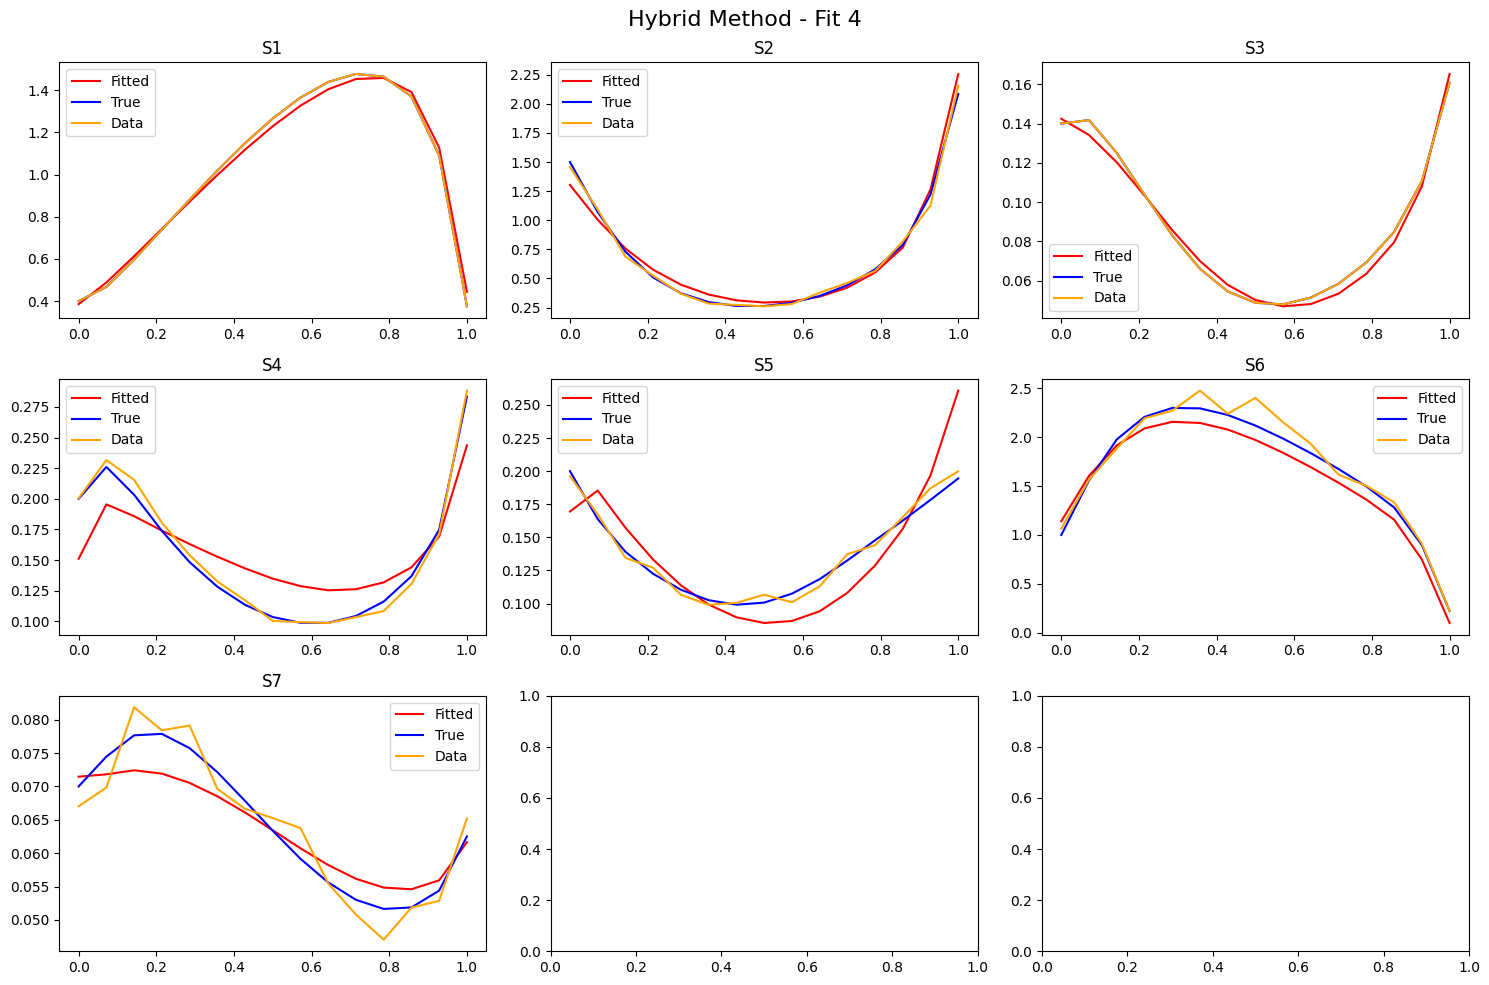

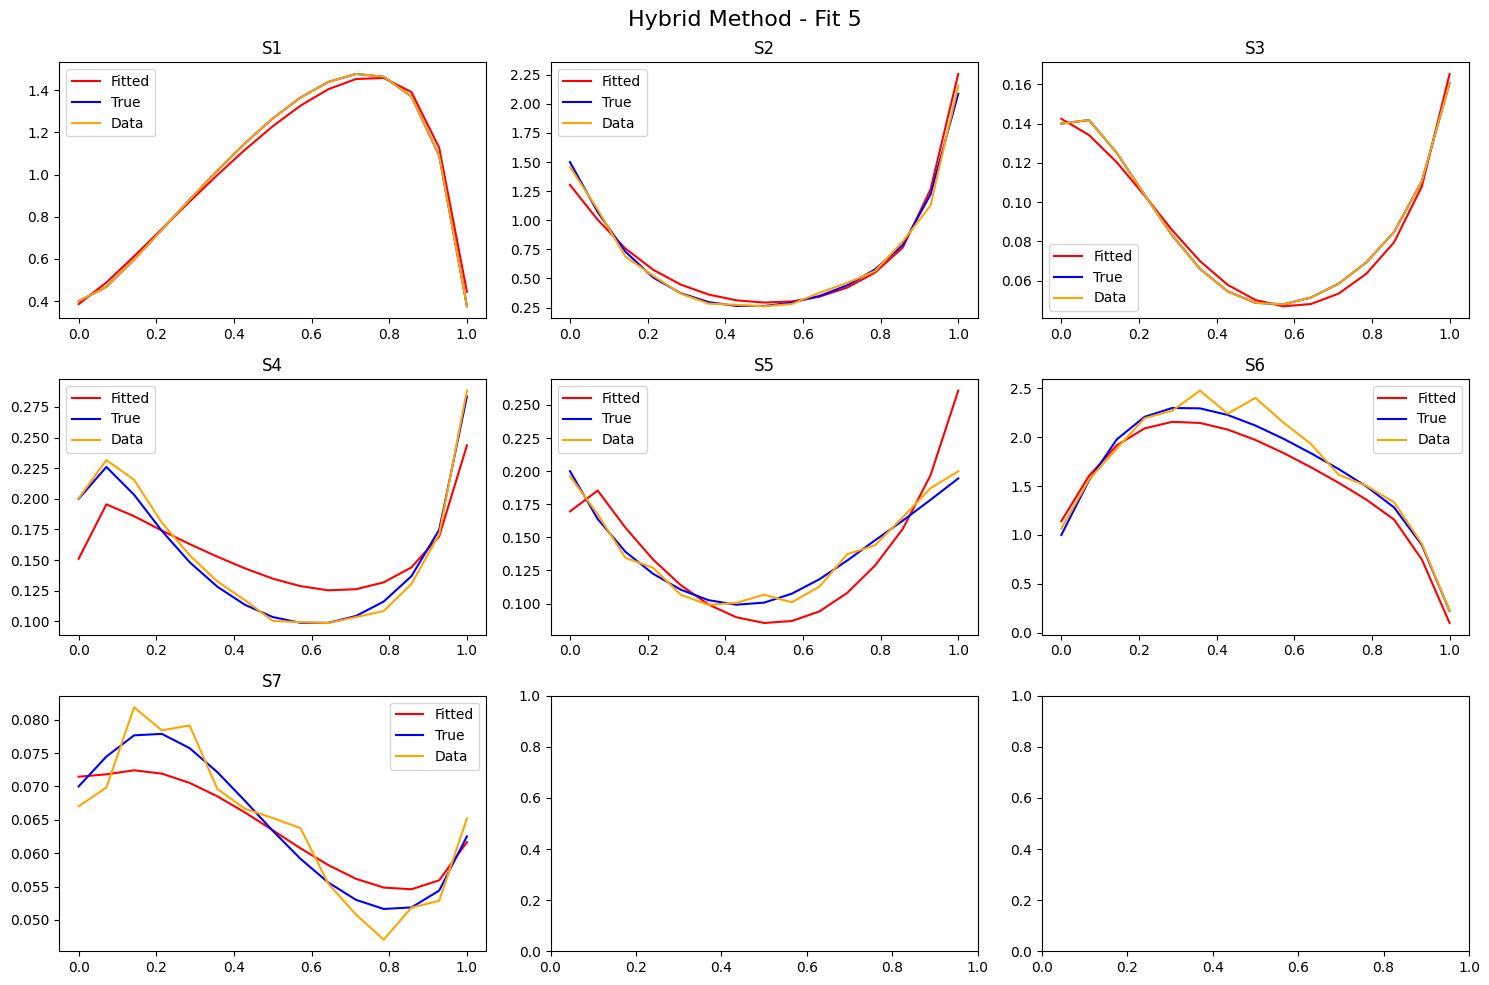

In [17]:
# [17]
# Sort the results by objective function value
sorted_hybrid_results = sorted(hybrid_results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_hybrid_results[:5]):
    plot_fit(result, 'Hybrid Method', idx)

In [18]:
# [18]
# Display per-variable fit values for the top results
def display_top_results(sorted_results, method_name):
    df_list = []
    for idx, result in enumerate(sorted_results[:10]):
        per_variable_distances = result['per_variable_distances']
        data = {'Fit Rank': idx+1, 'Total Objective': result['fun']}
        for i, var_name in enumerate(variable_names):
            data[var_name] = per_variable_distances[i]
        df_list.append(data)
    df = pd.DataFrame(df_list)
    print(f"Top 10 results for {method_name}:")
    display(df)

In [19]:
# [19]
display_top_results(sorted_results, 'Classical Method')
display_top_results(sorted_innovative_results, 'Innovative Method')
display_top_results(sorted_hybrid_results, 'Hybrid Method')

Top 10 results for Classical Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,3.534184,0.968118,0.253454,0.907330,0.308300,0.421573,0.340357,0.337574
1,2,4.271479,0.992923,0.315353,0.333137,1.183274,0.426959,0.333496,0.689600
2,3,4.432858,0.910022,0.306467,1.315242,0.318033,0.518216,0.721096,0.369884
3,4,5.897818,0.990667,0.548972,1.662662,0.668739,0.708416,0.552555,0.775916
4,5,6.158294,0.946861,0.397791,1.297982,0.370695,1.776496,1.158004,0.210465
5,6,6.718287,0.963661,0.332733,0.289430,0.892542,1.561572,0.806462,1.874612
6,7,11.287584,0.971959,1.005688,1.611522,0.570916,4.340693,1.620671,1.202635
7,8,11.771189,0.935231,0.913090,1.792442,2.439235,1.813423,0.556722,3.321045
8,9,12.144020,0.926313,0.448183,0.790976,1.132493,1.895224,0.890165,6.399352
9,10,21.097397,1.103941,0.311573,11.466821,3.820500,1.063861,0.679940,2.659419


Top 10 results for Innovative Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,2.072798,0.257989,0.238021,0.280232,0.288306,0.481805,0.135393,0.391052
1,2,2.072800,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
2,3,2.072800,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
3,4,2.072800,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
4,5,2.072800,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
5,6,2.072800,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
6,7,2.072801,0.257989,0.238021,0.280232,0.288306,0.481806,0.135393,0.391053
7,8,2.072801,0.257989,0.238021,0.280232,0.288307,0.481806,0.135393,0.391054
8,9,2.072803,0.257989,0.238021,0.280232,0.288307,0.481807,0.135393,0.391055
9,10,2.072930,0.257991,0.238027,0.280235,0.288327,0.481840,0.135394,0.391116


Top 10 results for Hybrid Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,0.622423,0.041722,0.044813,0.038447,0.117991,0.184569,0.075415,0.120697
1,2,0.627733,0.047968,0.040063,0.037135,0.112318,0.189662,0.085482,0.116787
2,3,0.696762,0.025352,0.039075,0.035732,0.143061,0.219789,0.095027,0.138746
3,4,0.709447,0.026813,0.041315,0.035692,0.148362,0.223945,0.090148,0.143336
4,5,0.709447,0.026813,0.041315,0.035692,0.148362,0.223945,0.090148,0.143336
5,6,0.711838,0.026201,0.041654,0.038910,0.149667,0.224196,0.086809,0.144528
6,7,0.711838,0.026201,0.041654,0.038910,0.149667,0.224196,0.086809,0.144528
7,8,0.711838,0.026201,0.041654,0.038910,0.149667,0.224196,0.086809,0.144528
8,9,0.714751,0.028163,0.042856,0.038708,0.148085,0.228145,0.086428,0.142496
9,10,0.720879,0.029329,0.039230,0.038722,0.152641,0.230117,0.089262,0.141824
